# MA332 Homework 5
#### *Ben Raivel*

In [1]:
import numpy as np
import scipy
from time import time
import matplotlib.pyplot as plt

## Problem 1.

$$
A =
\begin{pmatrix}
0 & 1 & 1\\
1 & -2 & 1\\
1 & -1 & 1
\end{pmatrix}
$$

## Problem 2.

### (a) Jacobi method implementation

In [14]:
def jacobi(A, b, x=None, tol=1e-6, precision=np.float32, verbose=False):
    """Solve the equation Ax = b for x
    
    Parameters:
    -----------
    - A: (n x n) matrix
    - b: (n x 1) vector
    - x (optional): Initial guess
    - tol: Forward error tolerance
    - precision: Type of float to use. For large matrices, using 16 or
        32 bits can be faster/more stable.
    - verbose: Whether to print the number of iterations taken.
    """
    # using 32 bit precision helps stop python from crashing
    # particularly on Problem 4
    if (A.dtype != precision.__name__):
        A = A.astype(precision)
        b = b.astype(precision)

    if x is None:  # make an initial guess (zeros)
        x = np.zeros(b.shape, dtype=precision)
    x_prev = np.zeros(b.shape, dtype=precision)
    
    # get diagonal of A and its inverse
    d = np.diag(A)
    d_inv = (1/d)

    # get D and D_inv as matrices
    D = d*np.eye(len(A), dtype=precision)
    D_inv = d_inv*np.eye(len(A), dtype=precision)

    # find (L + U)
    LU = A - D

    iter = 0
    error = np.inf

    # iterate until error is less than tol
    while error > tol:
        x_prev = x

        # update x
        x = np.dot(D_inv, b - np.dot(LU, x_prev))
        
        # calculate forward error
        error = np.linalg.norm(x - x_prev, ord=np.inf)

        iter += 1

    if verbose:
        print(f'Found x in {iter} iterations')

    return x

### b) Operations per iteration

Two lines of code update the approximation within the loop. The first is:
    
    x = np.dot(D_inv, b - np.dot(LU, x_prev))

This line consists of a matrix multiplication `np.dot(LU, x_prev)` ($n^2$ multiplications then $n^2$ additions), followed by subtraction of two $n \times 1$ vectors— `b` minus the result of the previous matrix multiplication (another $n$ operations), the resulting vector is then matrix-multiplied by $D^{-1}$ (requiring a further $n^2$ multiplications then $n^2$ additions). In total this line requires $n^2 + n^2 + n + n^2 + n^2 = \bf{4n^2 + n}$ operations.

The second line within the loop is:

    error = np.linalg.norm(x - x_prev, ord=np.inf)

This line consists of a subtraction of two $n \times 1$ vectors ($n$ operations), of which the $l_\infty$ norm is then taken. The $l_\infty$ norm for a vector $x$ is equivalent to `max(abs(x))`, so count this as a further $2n$ operations.

Combining the operation count of these two lines gives a total number of operations per iteration count of $4n^2 + 3n$, or a time-complexity of $\mathcal{O}(n^2)$

### c)

The system of equations can be written as a matrix equation of the form $Ax = b$:
$$
\begin{cases}
    10x_1 + 5x_2 = 6\\
    5x_1 + 10x_2 - 4x_3 = 25\\
    -4x_2 + 8x_3 - x_4 = -11\\
    -x_3 + 5x_4 = -11
\end{cases}
\qquad \rightarrow \qquad
\begin{pmatrix}
    10 & 5 & 0 & 0\\
    5 & 10 & -4 & 0\\
    0 & -4 & 8 & -1\\
    0 & 0 & -1 & 5
\end{pmatrix}
\begin{pmatrix}
    x_1\\
    x_2\\
    x_3\\
    x_4
\end{pmatrix} =
\begin{pmatrix}
    6\\
    25\\
    -11\\
    -11
\end{pmatrix}
$$

In [15]:
A = np.array([[10, 5, 0, 0],
              [5, 10, -4, 0],
              [0, -4, 8, -1],
              [0, 0, -1, 5]])

b = np.array([[6],
              [25],
              [-11],
              [-11]])

x = jacobi(A, b, tol=1e-5, verbose=True)
print(np.round(x, 2))

Found x in 33 iterations
[[-0.8 ]
 [ 2.8 ]
 [-0.26]
 [-2.25]]


### d)
The method took 33 iterations to find x within $10^{-5}$, this corresponds to $4(33)^2 + 3(33) = 4455$ operations.

## Problem 3.

### b)

In [24]:
def lu_backsolve(P, L, U, b):
    """Solve Ax = b given the LU-decomposition of A (PA = LU)
    
    Parameters:
    -----------
    - P: Permutation matrix, holds row swap information
    - L: Lower triangular component
    - U: Upper triangular component
    - b: (n x 1) vector
    """

    # apply inverse permutation matrix to b
    Pb = np.dot(P.T, b)

    # arrays to hold x, y values
    y = np.zeros(len(L))
    x = np.zeros(len(U))

    # forward substitution
    for i in range(len(L)):
        y[i] = (Pb[i] - np.dot(L[i, :i], y[:i]))/L[i, i]

    # backward substitution
    for i in reversed(range(len(U))):
        x[i] = (y[i] - np.dot(U[i, i:], x[i:]))/U[i, i]

    return x

### c)

In [25]:
A = np.array([[1, 1, 0, 3],
              [2, 1, -1, 1],
              [3, -1, -1, 2],
              [-1, 2, 3, -1]])

b = np.array([[8],
              [7],
              [14],
              [-7]])

p, l, u = scipy.linalg.lu(A)

x = lu_backsolve(p, l, u, b)

print(np.round(x, 2))

[ 3. -1. -0.  2.]


## Problem 4.

Define a function to create a $n \times n$ diagonally dominant matrix

In [18]:
def diag_dominant_mat(size):

    rng = np.random.default_rng()
    mat = 2*size*np.eye(size) + (rng.integers(4, size=(size, size)) - 2)
    
    return mat

In [19]:
sizes = [10, 100, 1000, 10000, 15000]

# Number of iterations to do at each size, inversely proportional to size
# helps with consistency (especially at small sizes)
n = [int(max(sizes)/s) for s in sizes]

lu_time = []
jacobi_time = []

for i, s in enumerate(sizes):
    print(f'Starting size {s}...')

    lu_total = 0
    jacobi_total = 0
    for _ in range(n[i]):
        mat = diag_dominant_mat(s)
        b = np.ones(s)

        lu_start = time()
        p, l, u = scipy.linalg.lu(mat)
        x = backsolve_lu(p, l, u, b)
        lu_end = time()
        lu_total += lu_end - lu_start

        jacobi_start = time()

        # python consistently crashes (both in the jupyter notebook
        # and running on the command line) with size=15000 and 
        # 32 or 64 bit precision, so use 16 bit float
        x = jacobi(mat, b, tol=1e-4, precision=np.float16)
        jacobi_end = time()
        jacobi_total += jacobi_end - jacobi_start

        del mat
        del p
        del l
        del u
    
    lu_time.append(lu_total/n[i])
    jacobi_time.append(jacobi_total/n[i])

Starting size 10...
Starting size 100...
Starting size 1000...
Starting size 10000...
Starting size 15000...


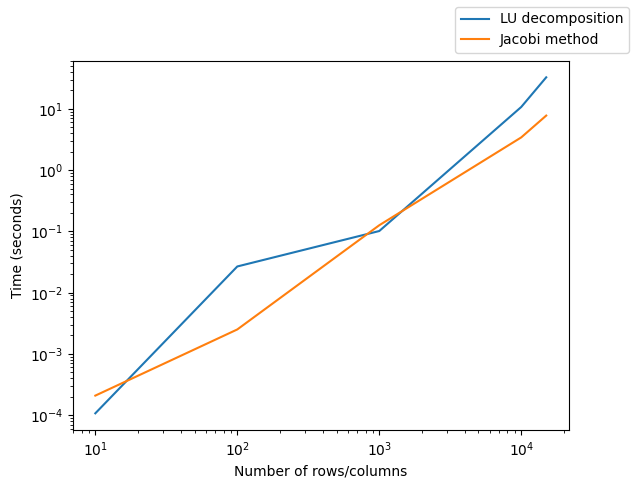

In [20]:
fig, ax = plt.subplots()

ax.plot(sizes, lu_time, label='LU decomposition')
ax.plot(sizes, jacobi_time, label='Jacobi method')

ax.loglog()
ax.set_xlabel('Number of rows/columns')
ax.set_ylabel('Time (seconds)')
fig.legend()

plt.show()

Based on the graph, the iterative method outperforms the direct method for $n \gtrapprox 20$.

#### Why isn't the Jacobi method much faster than LU decomposition/backsolve?
Short answer: it is, by my processor doesn't support 16 bit floating point math and the extra processing (by software) cuts into the advantage of using an iterative method.

To show this, run the same test as above but only up to a size of 10,000 with LU decomposition and the Jacobi method at 3 levels of precision (16, 32, and 64 bits):

In [21]:
sizes = [10, 100, 1000, 10000]

# Number of iterations to do at each size, inversely proportional to size
# helps with consistency (especially at small sizes)
n = 10*[int(max(sizes)/s) for s in sizes]

float16_time = []
float32_time = []
float64_time = []
lu_time = []

for i, s in enumerate(sizes):
    print(f'Starting size {s}...')
    
    float16_total_time = 0
    float32_total_time = 0
    float64_total_time = 0
    lu_total_time = 0
    
    # do multiple iterations at each size
    for _ in range(n[i]):

        # 16 Bit
        # ------
        mat = diag_dominant_mat(s).astype(np.float16)
        b = np.ones(s).astype(np.float16)

        # Jacobi Method
        float16_start = time()
        x = jacobi(mat, b, precision=np.float16, tol=1e-4)
        float16_end = time()
        float16_total_time += float16_end - float16_start

        # 32 Bit
        # ------
        mat = mat.astype(np.float32)
        b = b.astype(np.float32)

        # Jacobi Method
        float32_start = time()
        x = jacobi(mat, b, tol=1e-4)
        float32_end = time()
        float32_total_time += float32_end - float32_start

        # 64 Bit
        # ------
        mat = mat.astype(np.float64)
        b = b.astype(np.float64)

        # Jacobi Method
        float64_start = time()
        x = jacobi(mat, b, precision=np.float64, tol=1e-4)
        float64_end = time()
        float64_total_time += float64_end - float64_start

        # LU Decomposition
        lu_start = time()
        p, l, u = scipy.linalg.lu(mat)
        x = backsolve_lu(p, l, u, b)
        lu_end = time()
        lu_total_time += lu_end - lu_start

        del mat  # give the GC some help
    
    # Record average values
    float16_time.append(float16_total_time/n[i])
    float32_time.append(float32_total_time/n[i])
    float64_time.append(float64_total_time/n[i])
    lu_time.append(lu_total_time/n[i])

Starting size 10...
Starting size 100...
Starting size 1000...
Starting size 10000...


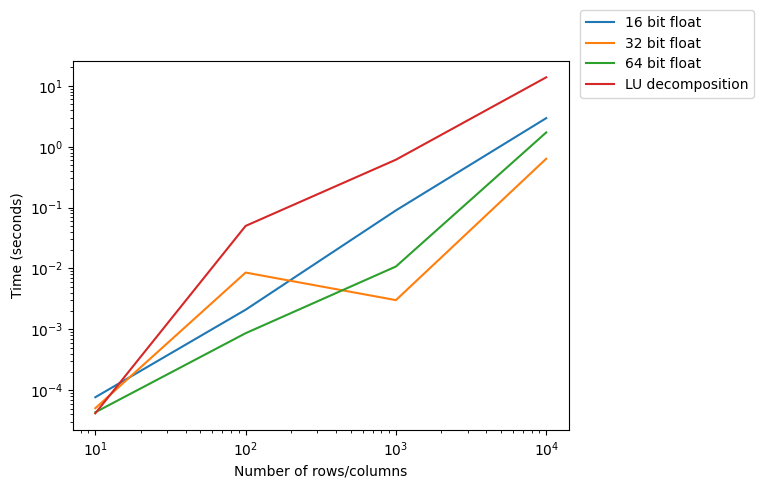

In [23]:
fig, ax = plt.subplots()

ax.plot(sizes, float16_time, label='16 bit float')
ax.plot(sizes, float32_time, label='32 bit float')
ax.plot(sizes, float64_time, label='64 bit float')
ax.plot(sizes, lu_time, label='LU decomposition')

ax.loglog()
ax.set_xlabel('Number of rows/columns')
ax.set_ylabel('Time (seconds)')

fig.legend(bbox_to_anchor=(1.2,1))

plt.show()

With this graph, it is clear that the Jacobi method significantly outperforms LU decomposition/backsolve. The advantage is more than 1 order of magnitude for sizes greater than 1,000 with 32 bit floats (the smallest supported by my processor). 64 bit floats are better than 32 bit ones at small sizes but worse with larger matrices. 16 bit floats are the worst in terms of computational efficiency but the reduced memory pressure prevents python from crashing with large matrices ($n=15,000$ is 1.8 GB in 64 bit floats vs 450 MB in 16 bit floats).

## Problem 5.

In [ ]:
def is_diag_dominant(A):

    d = np.diag(A)

    D = d*np.eye(len(A))

    # get A without the diagonal entries
    R = A - D

    sum_row_mags = np.sum(np.abs(R), axis=1)

    if (d > sum_row_mags).all():
        return True
    else:
        return False

In [ ]:
is_diag_dominant(diag_dominant_mat(10))

True

In [ ]:
is_diag_dominant(np.ones((10, 10)))

False

## 6.

### (a)

If no rows are swapped, then $P$ is the identity matrix and $\text{det} P = 1$.

Any permutation matrix can be obtained by swapping the rows of the identity matrix. Swapping rows changes the sign of the determinant: after one swap $\text{det} P = -1$, after two swaps $\text{det} P = 1$, etc.

The determinant of a permutation matrix which performs $k$ row swaps can therefore be written as:
$$\text{det} P = (-1)^k$$

### (b)

Finding $\text{det} P^T$ requires counting the number of zeros on the diagonal of $P$ ($\sim n$ operations).
$\text{det} L$ and $\text{det} U$ can be found using the properties of block matrices, particularly:
$$
\text{det}
\begin{pmatrix}
A & 0\\
C & D
\end{pmatrix} =
\text{det}
\begin{pmatrix}
A & B\\
0 & D
\end{pmatrix} = \text{det} A \cdot \text{det} D
$$
To find $\text{det} L$ and $\text{det} U$ (for $n \times n$ matrices $L$ and $U$), divide the matrix into $n/2$, $2 \times 2$ matrices along the diagonal (if n is odd, then the determinant of the last $1 \times 1$ matrix is just the value in that matrix), for each one compute the determinant according to:
$$
\text{det}
\begin{pmatrix}
a & b\\
c & d
\end{pmatrix} = ad - bc
$$
Computing each determinant takes 3 operations, or $\frac{3}{2}n$ for the whole matrix, plus another $n/2$ multiplications to combine them.

In total, computing $\text{det} A$ (assuming LU decomposition has already been performed) requires $5n$ operations ($n$ to find $\text{det} P^T$ and $2n$ each to find $\text{det}L$ and $\text{det}U$). 